

---
**IMPORTS**

---




In [ ]:
!pip install conllu
!git clone https://github.com/UniversalDependencies/UD_Sanskrit-Vedic/

import warnings 
import numpy as np
from io import open
import pandas as pd
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from conllu import parse_incr, parse
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold, cross_val_score
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.metrics import classification_report, accuracy_score

from keras import models
from keras import layers
from keras.optimizers import Nadam
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Dropout, Flatten

fatal: destination path 'UD_Sanskrit-Vedic' already exists and is not an empty directory.



---
**READING THE DATASET**

---

In [ ]:
def read_data(data_file):

  tokenlist = parse_incr(data_file)
  sentences = []

  for tokens in tokenlist:
    new_list = []
    for t in tokens:
      new_list.append((t['lemma'], t['upos']))
    sentences.append(new_list)

  return sentences


train_data_file = open("/content/UD_Sanskrit-Vedic/sa_vedic-ud-train.conllu", "r", encoding="utf-8")
test_data_file = open("/content/UD_Sanskrit-Vedic/sa_vedic-ud-test.conllu", "r", encoding="utf-8")

train_sentences = read_data(train_data_file)
test_sentences = read_data(test_data_file)

print(len(train_sentences), len(test_sentences))

2524 1473



---

**FEATURE GENERATION**

---

In [ ]:
def create_features_set(sentence_terms, index):
    
  term = sentence_terms[index]

  return {
      'nb_terms': len(sentence_terms),
      'term': term,
      'is_first': index == 0,
      'is_last': index == len(sentence_terms) - 1,
      'is_capitalized': term[0].upper() == term[0],
      'is_all_caps': term.upper() == term,
      'is_all_lower': term.lower() == term,
      'prefix-1': term[0],
      'prefix-2': term[:2],
      'prefix-3': term[:3],
      'suffix-1': term[-1],
      'suffix-2': term[-2:],
      'suffix-3': term[-3:],
      'prev_word': '' if index == 0 else sentence_terms[index - 1],
      'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
  }


def create_dataset(tagged_sentences):
    
  X, y, words = [], [], []

  for pos_tags in tagged_sentences:
    for index, (term, class_) in enumerate(pos_tags):
        words.append(term)
        X.append(create_features_set([w for w, _ in pos_tags], index))
        y.append(class_)

  return X, y, words

In [ ]:
X_train, y_train, train_unprocessed_features = create_dataset(train_sentences)
X_test, y_test, test_unprocessed_features = create_dataset(test_sentences)
train_unprocessed_labels, test_unprocessed_labels = y_train, y_test

In [ ]:
split_percent = 1.0 # SPLITTING THE TRAINING DATA
X_train = X_train[:int(len(X_train) * split_percent)] 
y_train = y_train[:int(len(y_train) * split_percent)]
train_unprocessed_labels = train_unprocessed_labels[:int(len(train_unprocessed_labels) * split_percent)]

In [ ]:
print('Total lables Train: ' + str(len(train_unprocessed_labels)) + '\n')
Counter(train_unprocessed_labels)

Total lables Train: 17445



Counter({'ADJ': 1503,
         'ADV': 1860,
         'AUX': 211,
         'CCONJ': 462,
         'DET': 117,
         'NOUN': 5768,
         'NUM': 203,
         'PART': 1105,
         'PRON': 2705,
         'SCONJ': 168,
         'VERB': 3343})

In [ ]:
print('Total lables Test: ' + str(len(test_unprocessed_labels)) + '\n')
Counter(test_unprocessed_labels)

Total lables Test: 9672



Counter({'ADJ': 870,
         'ADV': 1084,
         'AUX': 90,
         'CCONJ': 152,
         'DET': 48,
         'NOUN': 3074,
         'NUM': 89,
         'PART': 785,
         'PRON': 1443,
         'SCONJ': 97,
         'VERB': 1940})

---
**FEATURES ENCODING**

---

In [ ]:
dv = DictVectorizer(sparse=False)
dv.fit(X_train + X_test)

X_train = dv.transform(X_train)
X_test = dv.transform(X_test)


---
**LABELS ENCODING**

---

In [ ]:
le = LabelEncoder()
le.fit(y_train + y_test)

y_train = le.transform(y_train)
y_test = le.transform(y_test)


---
**CLASSIFICATION**

---

In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(11, activation='softmax'))

optimizer = Nadam(lr=0.0005,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  schedule_decay=0.004)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(X_train,
                    y_train,
                    epochs=7,
                    batch_size=128)

test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/7
137/137 [==============================] - 1s 8ms/step - loss: 0.9371 - accuracy: 0.7201
Epoch 2/7
137/137 [==============================] - 1s 7ms/step - loss: 0.1903 - accuracy: 0.9424
Epoch 3/7
137/137 [==============================] - 1s 7ms/step - loss: 0.1003 - accuracy: 0.9686
Epoch 4/7
137/137 [==============================] - 1s 8ms/step - loss: 0.0665 - accuracy: 0.9786
Epoch 5/7
137/137 [==============================] - 1s 8ms/step - loss: 0.0526 - accuracy: 0.9837
Epoch 6/7
137/137 [==============================] - 1s 7ms/step - loss: 0.0431 - accuracy: 0.9860
Epoch 7/7
303/303 [==============================] - 1s 3ms/step - loss: 0.2953 - accuracy: 0.9233


In [ ]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')


---
**EVALUATION**

---

In [ ]:
# Predict the labels for the test data
pred_labels_tree = tree.predict(X_test)

class_rep_tree = accuracy_score(y_test, pred_labels_tree)

print("DT - test accuracy: \n", class_rep_tree)
print("DNN - test accuracy: \n", test_acc)

DT - test accuracy: 
 0.9166666666666666
DNN - test accuracy: 
 0.9232836961746216


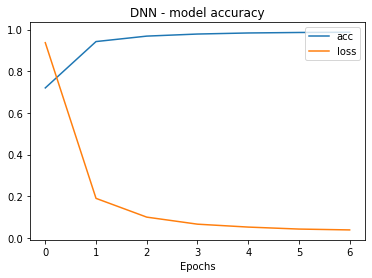

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('DNN - model accuracy')
plt.xlabel('Epochs')
plt.legend(['acc', 'loss'], loc='upper right')
fig1 = plt.gcf()
plt.show()



---

**CORRECT & INCORRECT CLASSIFICATIONS**

---



In [ ]:
df = pd.DataFrame(test_unprocessed_features, columns=["input"])

df["actual"] = test_unprocessed_labels
df["predicted"] = le.inverse_transform(pred_labels_tree)

correct = df[df["actual"] == df["predicted"]]
incorrect = df[df["actual"] != df["predicted"]]

In [ ]:
correct.head()

,input,actual,predicted
0,yad,PRON,PRON
3,viśva,DET,DET
4,rūpa,NOUN,NOUN
5,bhṛ,VERB,VERB
6,vācaspati,NOUN,NOUN


In [ ]:
incorrect.head()

,input,actual,predicted
1,triṣapta,ADJ,NOUN
2,parī,VERB,NOUN
16,deva,ADJ,NOUN
53,śru,VERB,NOUN
58,śru,VERB,NOUN


In [ ]:
print('Incorrect Predictions on Test data:\n')
incorrect['predicted'].value_counts() # MOSTLY NOUN MAYBE BECAUSE NOUN HAS MAX SAMPLES

Incorrect Predictions on Test data:



NOUN     367
VERB     130
ADJ      108
ADV       74
PRON      72
DET       16
AUX       15
NUM       12
SCONJ      8
PART       4
Name: predicted, dtype: int64